In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sns
import csv
from scipy.signal import butter, lfilter

2024-12-29 14:03:14.170025: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-29 14:03:14.249299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-29 14:03:14.280176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-29 14:03:14.288915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 14:03:14.347118: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Found GPU")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Found GPU


I0000 00:00:1735477398.756372   21892 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735477398.847262   21892 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735477398.848401   21892 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
def get_spectrogram(pcm):
    D = librosa.stft(pcm, n_fft=256, hop_length=128, window='hann')
    return np.abs(D)

# Load data

In [83]:
data = []
with open("data/audio_data_8.csv", 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        data.append(float(row['y']))  # Convert to int if y is numeric
        
# data = np.array(data, dtype=np.float32)
# resampled = librosa.resample(data, orig_sr=40e3, target_sr=16e3)
# selected = resampled[int(10e3):int(26e3)]

selected = np.array(data, dtype=np.float32)

In [84]:
len(selected)

16000

In [86]:
display.Audio(selected, rate=16e3)

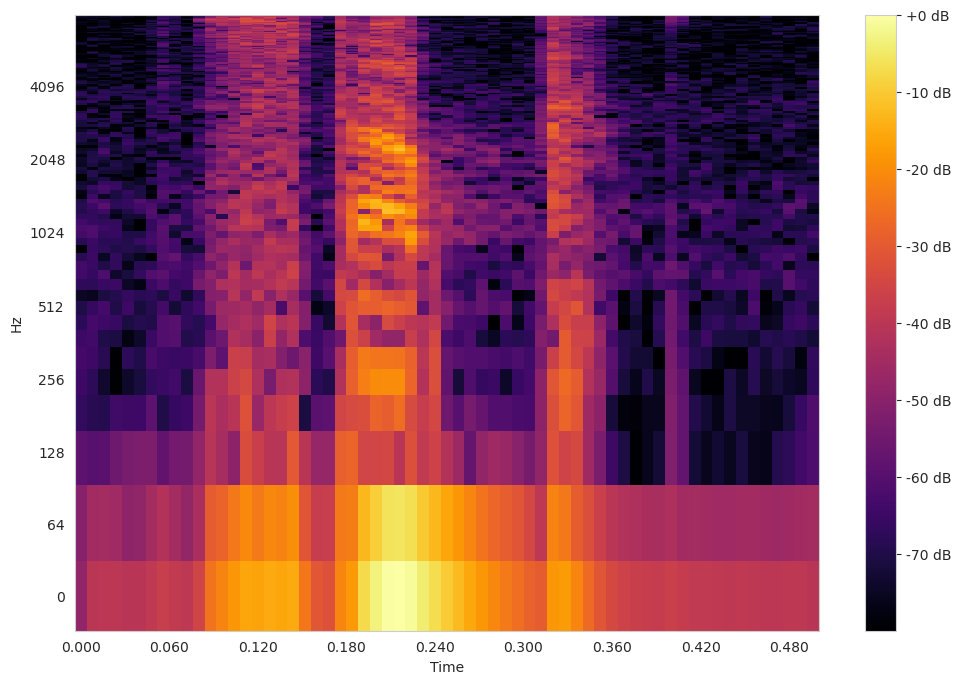

In [54]:
D = librosa.stft(selected, n_fft=256, hop_length=128, window='hann')

# Convert the complex-valued STFT to a magnitude spectrogram
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=16000, cmap='inferno', hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

# Filter

In [87]:
fs = 16e3
cutoff = 3.9e3
nyquist = 0.5 * fs 
normal_cutoff = cutoff / nyquist
b, a = butter(3, normal_cutoff, btype='lowpass', analog=False)

y = lfilter(b, a, selected)
y = [0 if item is None else item for item in y]
y = np.array(y, dtype=np.float32)

fs = 8e3
cutoff = 100
nyquist = 0.5 * fs 
normal_cutoff = cutoff / nyquist
b, a = butter(6, normal_cutoff, btype='highpass', analog=False)

y_highpass = lfilter(b, a, y)
y_highpass = [0 if item is None else item for item in y_highpass]
y_highpass= np.array(y_highpass, dtype=np.float32)

In [88]:
display.Audio(selected, rate=16e3)

In [89]:
len(selected)

16000

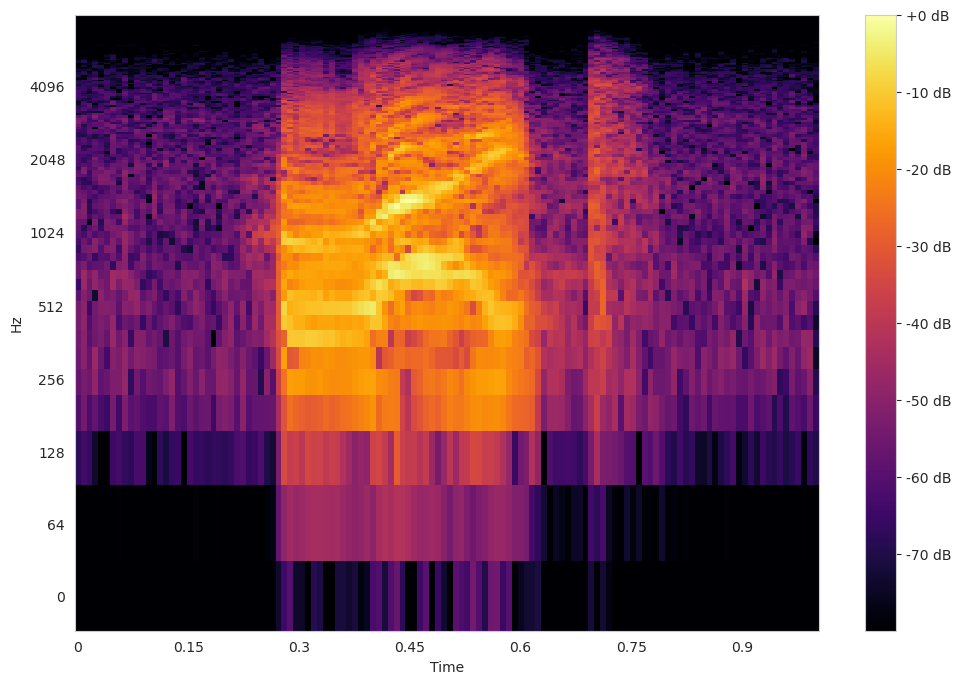

In [90]:
D = librosa.stft(y_highpass, n_fft=256, hop_length=128, window='hann')

# Convert the complex-valued STFT to a magnitude spectrogram
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=16000, cmap='inferno', hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [91]:
test_data = np.array([get_spectrogram(selected)])

In [92]:
test_data = test_data.reshape(len(test_data), test_data[0].shape[0], test_data[0].shape[1], 1)

In [93]:
test_data.shape

(1, 129, 126, 1)

# Load net

In [78]:
#model = tf.keras.models.load_model("tra_prototype_model_87test_acc_balanced_classes.h5")
model = tf.keras.models.load_model("tra_prototype_model.keras")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       173,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 815,597 (3.11 MB)

 Trainable params: 271,864 (1.04 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 543,730 (2.07 MB)

In [94]:
y_pred = np.argmax(model.predict(test_data), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


In [95]:
model.predict(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [96]:
label_strings = [ "go", "left", "no", "right", "stop", "yes", "silence", "unknown"]
selected_labels_dict = {i:x for i, x in enumerate(label_strings)}

In [97]:
print(f"Predicted word: {selected_labels_dict.get(float(y_pred))}")

Predicted word: right


/tmp/ipykernel_21892/237502318.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Predicted word: {selected_labels_dict.get(float(y_pred))}")


# Class labels
- 0 - "go"
- 1 - "left"
- 2 - "no"
- 3 - "right"
- 4 - "stop"
- 5 - "yes"
- 6 - "silence"
- 7 - "unknown"
